In [99]:
from py2neo import Graph,Node,Relationship
import pandas as pd
import matplotlib.pyplot as plot

In [4]:
graph = Graph('http://localhost:7474', auth=('neo4j', 'xxxx'))

# Load Data

The data load scripts below have been maintained in markdown as they have been run in the neo4j desktop app rather than via Jupyter

### Load customer CSV data

In [127]:
graph.run('LOAD CSV WITH HEADERS FROM "file:///customers.csv" AS row CREATE (c:Customer) SET c += row')

(No data)

### Load accounts data


In [129]:
graph.run("""LOAD CSV WITH HEADERS FROM "file:///accounts.csv" AS row 
 CREATE (:Account {account_id : row.account_id, customer_id : row.customer_id,
 account_type : row.account_type, channel:row.channel })""")

(No data)

### Create relationship between customer and accounts 


In [130]:
graph.run("""LOAD CSV WITH HEADERS FROM "file:///accounts.csv" AS row 
MATCH (account : Account {account_id : row.account_id })
MATCH (customer:Customer) WHERE customer.customer_id = row.customer_id
CREATE (customer)-[:HAS]->(account)""")

(No data)

### Load funds data


In [131]:
graph.run("""LOAD CSV WITH HEADERS FROM "file:///funds.csv" AS row
CREATE (c:Fund)
SET c += row""")

(No data)

### Load account purchase data and create a relationship between account and fund 


In [132]:
graph.run("""LOAD CSV WITH HEADERS FROM "file:///account_purchases.csv" AS row 
MATCH (account : Account {account_id : row.account_id })
MATCH (fund:Fund) WHERE fund.ticker = row.ticker
CREATE (account)-[:PURCHASED {Num_Shares:row.number_of_shares, Purchase_Date:row.purchase_date}]->(fund)""")

(No data)

### Load a subset of account purchases as stock 

In [135]:
graph.run("""LOAD CSV WITH HEADERS FROM "file:///account_purchases.csv" AS row
WITH row
WHERE NOT row.ticker  IN ["VDIGX", "VMGAX", "VRNIX", "VFAIX" ,"VFIAX"] 
CREATE (:Stock {ticker : row.ticker})""")

(No data)

### create relatopnship between account and stock 


In [136]:
graph.run("""LOAD CSV WITH HEADERS FROM "file:///account_purchases.csv" AS row
MATCH (account : Account {account_id : row.account_id })
MATCH (stock: Stock {ticker: row.ticker})
CREATE (stock)<-[:PURCHASED{Num_Shares:row.number_of_shares, Purchase_Date:row.purchase_date}]-(account)""")

(No data)

# Question 2a Find all Accounts that own MSFT stock directly through an individual account


In [137]:
Msft_Accounts = 'MATCH (c:Customer) --  (a:Account {account_type: "Individual"})  -- (s:Stock {ticker: "MSFT"}) RETURN distinct c.owner_name,  a.account_id'

In [138]:
df_Msft_Accounts  = graph.run(Msft_Accounts).to_data_frame()

In [139]:
display(df_Msft_Accounts)


,c.owner_name,a.account_id
0,Ed Chowder,923457
1,Dan Nivalf,7009001
2,Alex R. Jones,123457


# Question 2b Find all Accounts that hold MSFT through a mutual fund.

### Load fund holdings and create a relationship to fund holding 


In [140]:
graph.run("""LOAD CSV WITH HEADERS FROM 'file:///fund_holdings.csv' AS row
MATCH (Fund : Fund {ticker : row.fund_ticker })
where Fund.ticker = row.fund_ticker
CREATE (Fund)-[:HOLDS]->(ticker:fund_holding { percentage:row.percentage, holding_ticker:row.holding_ticker, fund_ticker:row.fund_ticker})""")

(No data)

In [141]:

Msft_Mutual_Accounts = """MATCH (c:Customer) -[:HAS]->  (a:Account) 
-[:PURCHASED]->(f:Fund) -[:HOLDS]-> (fh:fund_holding {holding_ticker: "MSFT"})
RETURN distinct c.owner_name,  a.account_id """

In [142]:
df_Msft_Mutual_Accounts = graph.run(Msft_Mutual_Accounts).to_data_frame()
display(df_Msft_Mutual_Accounts)

,c.owner_name,a.account_id
0,Ed Chowder,923457
1,Alex R. Jones,123456
2,Alex R. Jones,123457
3,Ed Chowder,923456
4,Alex R. Jones,123458
5,Ed Chowder,923458
6,Soham Dipkar,7009991


# Question 2c Return a count of the number of times a fund holds a stock, sorted in descending count order

In [143]:
Fund_Holds_Stock_Count = """
MATCH (fh:fund_holding) 
RETURN fh.holding_ticker, count(fh.fund_ticker) 
ORDER BY COUNT(fh.fund_ticker) DESC """

In [144]:
df_Fund_Holds_Stock_Count = graph.run(Fund_Holds_Stock_Count).to_data_frame()
display(df_Fund_Holds_Stock_Count)

,fh.holding_ticker,count(fh.fund_ticker)
0,MSFT,3
1,AAPL,3
2,AMZN,3
3,FB,3
4,GOOGL,3
5,GOOG,3
6,JPM,3
7,BRK.B,3
8,XOM,2
9,NKE,1


# Question 2d Return the value of mutual fund holdings owned by ‘Ed Chowder’ close date = 5/15/18. Calculate the value of the fund holdings and order by fund name.

### load daily close data and create relationship from fund to fund_value 


In [145]:
graph.run("""LOAD CSV WITH HEADERS FROM 'file:///daily_close.csv' AS row
MATCH (Fund : Fund {ticker : row.ticker})
CREATE (Fund)-[:HAS_VALUE]->(close:fund_value {ticker:row.ticker, close:row.close, date:row.date, numshares:row.Num_Shares})
""")

(No data)

In [146]:
Ed_Chowder_Mutual_Value = """
MATCH (c:Customer  {owner_name: 'Ed Chowder'}) -[:HAS]->  (a:Account) -[p:PURCHASED]-> (f:Fund)-[:HAS_VALUE]->(fv:fund_value {date: "2018-05-15"}) 
RETURN c.owner_name, (a.account_id), f.ticker, f.fund_name, Round(SUM(toFloat(fv.close)*toFloat(p.Num_Shares)),1) As Value 
ORDER BY f.fund_name """

In [147]:
df_Ed_Chowder_Mutual_Value = graph.run(Ed_Chowder_Mutual_Value).to_data_frame()

df_Ed_Chowder_Mutual_Value.sort_values(by=['f.fund_name'])

,c.owner_name,(a.account_id),f.ticker,f.fund_name,Value
0,Ed Chowder,923456,VFIAX,Vanguard 500 Index Fund,225783.0
1,Ed Chowder,923457,VDIGX,Vanguard Dividend Growth Fund,1324.5
2,Ed Chowder,923456,VDIGX,Vanguard Dividend Growth Fund,31788.0
3,Ed Chowder,923458,VFAIX,Vanguard Financial Index Fund,10338.5
4,Ed Chowder,923456,VFAIX,Vanguard Financial Index Fund,14260.0
5,Ed Chowder,923456,VMGAX,Vanguard Mega Cap Growth Index Fund,23192.0
6,Ed Chowder,923458,VRNIX,Vanguard Russell 1000 Index Fund,84476.0
7,Ed Chowder,923456,VRNIX,Vanguard Russell 1000 Index Fund,48272.0


# Question 3a Return account owner name(s) and account type(s) that own MSFT stock directly through an individual account or through a mutual fund. You do not have to count the number of account types a person owns (e.g. owner has more than one account type “Individual”)


In [148]:
Msft_Individual_Or_Mututal = """
MATCH (c:Customer) -[:HAS]->  (a:Account) -[:PURCHASED]->(f:Fund) -[:HOLDS]-> (fh:fund_holding {holding_ticker: 'MSFT'})  
 RETURN DISTINCT c.owner_name,  a.account_id,  fh.holding_ticker as Ticker 
 UNION 
 MATCH   (c:Customer) -[:HAS]->(a:Account) -[:PURCHASED]->(s:Stock {ticker : 'MSFT'})  
 RETURN DISTINCT c.owner_name,  a.account_id,  s.ticker as Ticker """

In [149]:
df_Msft_Individual_Or_Mututal = graph.run(Msft_Individual_Or_Mututal).to_data_frame()
display(df_Msft_Individual_Or_Mututal)

,c.owner_name,a.account_id,Ticker
0,Ed Chowder,923456,MSFT
1,Alex R. Jones,123457,MSFT
2,Alex R. Jones,123456,MSFT
3,Ed Chowder,923457,MSFT
4,Ed Chowder,923458,MSFT
5,Alex R. Jones,123458,MSFT
6,Soham Dipkar,7009991,MSFT
7,Dan Nivalf,7009001,MSFT


# Question 3b Return account owner name(s), account type(s), the fund or stock they own and total the value for the last day in the daily trading data. Do not hard code the last day in the query.

In [150]:
Accounts_Last_Day = """
MATCH (fva:fund_value) 
WITH max(fva.date) AS latest_date 
MATCH (c:Customer) -[:HAS]->  (a:Account) -[p:PURCHASED]->(f:Fund) -[:HAS_VALUE]->(fv:fund_value {date:latest_date}) 
RETURN c.owner_name, a.account_type, fv.date, f.ticker, (toFloat(fv.close)*toFloat(p.Num_Shares)) as value 
"""

In [151]:
df_Accounts_Last_Day = graph.run(Accounts_Last_Day).to_data_frame()
display(df_Accounts_Last_Day)

,c.owner_name,a.account_type,fv.date,f.ticker,value
0,Alex R. Jones,401k,2018-06-22,VDIGX,2675.00
1,Alex R. Jones,Individual,2018-06-22,VDIGX,13375.00
2,Ed Chowder,401k,2018-06-22,VDIGX,32100.00
3,Ed Chowder,Individual,2018-06-22,VDIGX,1337.50
4,Alex R. Jones,401k,2018-06-22,VMGAX,48146.00
5,Ed Chowder,401k,2018-06-22,VMGAX,24073.00
6,Alex R. Jones,401k,2018-06-22,VRNIX,98524.00
7,Alex R. Jones,529 Plan,2018-06-22,VRNIX,12315.50
8,Ed Chowder,401k,2018-06-22,VRNIX,49262.00
9,Ed Chowder,529 Plan,2018-06-22,VRNIX,86208.50


# Visualisations

### A plot of account value by account owner

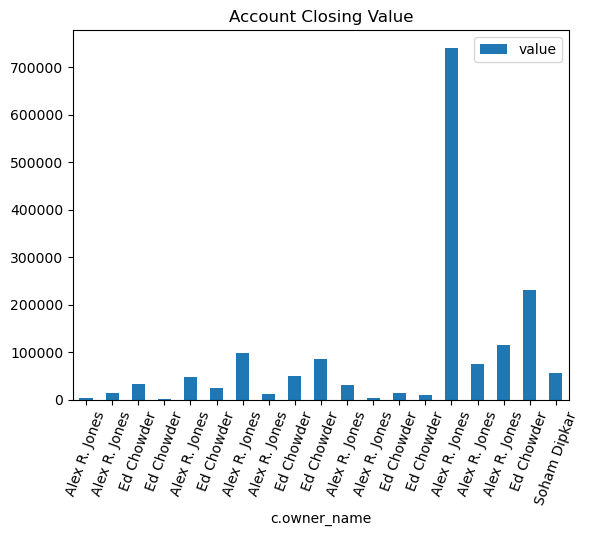

In [152]:
df_Accounts_Last_Day.plot.bar(x='c.owner_name', y='value', rot=70, title="Account Closing Value");

plot.show(block=True);

### The above is grouped by the account/ticker. Aggregate to see the total value by each customer

In [153]:
df_Customer_Last_Day = df_Accounts_Last_Day.groupby(['c.owner_name'])['value'].sum()


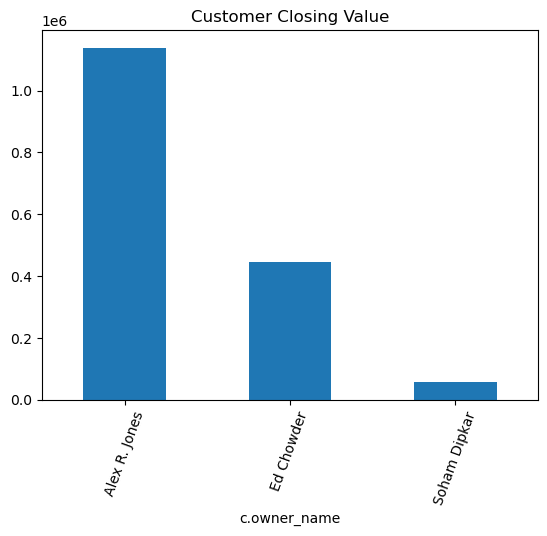

In [154]:
df_Customer_Last_Day.plot.bar(x='c.owner_name', y='value', rot=70, title="Customer Closing Value");

plot.show(block=True);

### Ed Chowder 5/15/18 total value by fund 

In [155]:
df_Ed_Chowder_Mutual_Value

,c.owner_name,(a.account_id),f.ticker,f.fund_name,Value
0,Ed Chowder,923456,VFIAX,Vanguard 500 Index Fund,225783.0
1,Ed Chowder,923457,VDIGX,Vanguard Dividend Growth Fund,1324.5
2,Ed Chowder,923456,VDIGX,Vanguard Dividend Growth Fund,31788.0
3,Ed Chowder,923458,VFAIX,Vanguard Financial Index Fund,10338.5
4,Ed Chowder,923456,VFAIX,Vanguard Financial Index Fund,14260.0
5,Ed Chowder,923456,VMGAX,Vanguard Mega Cap Growth Index Fund,23192.0
6,Ed Chowder,923458,VRNIX,Vanguard Russell 1000 Index Fund,84476.0
7,Ed Chowder,923456,VRNIX,Vanguard Russell 1000 Index Fund,48272.0


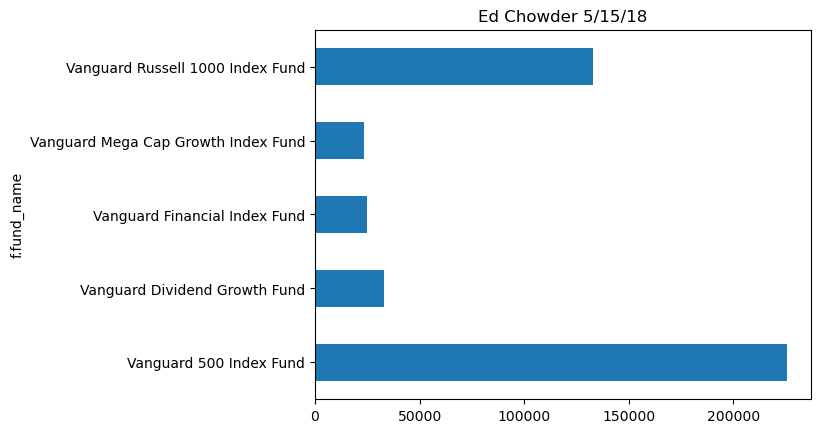

In [157]:
df_Ed_Chowder_Mutual_Agg_Value = df_Ed_Chowder_Mutual_Value.groupby(['f.fund_name'])['Value'].sum()

df_Ed_Chowder_Mutual_Agg_Value.plot.barh( x='Value', y='f.fund_name', title="Ed Chowder 5/15/18");

plot.show(block=True);